In [1]:
# Google Colab에서 노트북을 실행하실 때에는
# https://tutorials.pytorch.kr/beginner/colab 를 참고하세요.
%matplotlib inline


[파이토치(PyTorch) 기본 익히기](intro.html) ||
**빠른 시작** ||
[텐서(Tensor)](tensorqs_tutorial.html) ||
[Dataset과 Dataloader](data_tutorial.html) ||
[변형(Transform)](transforms_tutorial.html) ||
[신경망 모델 구성하기](buildmodel_tutorial.html) ||
[Autograd](autogradqs_tutorial.html) ||
[최적화(Optimization)](optimization_tutorial.html) ||
[모델 저장하고 불러오기](saveloadrun_tutorial.html)

# 빠른 시작(Quickstart)
이번 장에서는 기계 학습의 일반적인 작업들을 위한 API를 통해 실행됩니다. 더 자세히 알아보려면 각 장(section)의 링크를 참고하세요.

## 데이터 작업하기
파이토치(PyTorch)에는 [데이터 작업을 위한 기본 요소](https://pytorch.org/docs/stable/data.html) 두가지인
``torch.utils.data.DataLoader`` 와 ``torch.utils.data.Dataset`` 가 있습니다.
``Dataset`` 은 샘플과 정답(label)을 저장하고, ``DataLoader`` 는 ``Dataset`` 을 순회 가능한 객체(iterable)로 감쌉니다.


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

PyTorch는 [TorchText](https://pytorch.org/text/stable/index.html), [TorchVision](https://pytorch.org/vision/stable/index.html) 및
[TorchAudio](https://pytorch.org/audio/stable/index.html) 와 같이 도메인 특화 라이브러리를 데이터셋과 함께 제공하고 있습니다.
이 튜토리얼에서는 TorchVision 데이터셋을 사용하도록 하겠습니다.

``torchvision.datasets`` 모듈은 CIFAR, COCO 등과 같은 다양한 실제 비전(vision) 데이터에 대한
``Dataset``\ ([전체 목록은 여기](https://pytorch.org/vision/stable/datasets.html))\ 을 포함하고 있습니다.
이 튜토리얼에서는 FasionMNIST 데이터셋을 사용합니다.
모든 TorchVision ``Dataset`` 은 샘플과 정답을 각각 변경하기 위한 ``transform`` 과 ``target_transform`` 의 두 인자를 포함합니다.



In [3]:
# 공개 데이터셋에서 학습 데이터를 내려받습니다.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# 공개 데이터셋에서 테스트 데이터를 내려받습니다.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26421880/26421880 [00:01<00:00, 13351862.93it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 207541.34it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3877580.01it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15876674.26it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



``Dataset`` 을 ``DataLoader`` 의 인자로 전달합니다. 이는 데이터셋을 순회 가능한 객체(iterable)로 감싸고, 자동화된 배치(batch), 샘플링(sampling),
섞기(shuffle) 및 다중 프로세스로 데이터 불러오기(multiprocess data loading)를 지원합니다. 여기서는 배치 크기(batch size)를 64로 정의합니다.
즉, 데이터로더(dataloader) 객체의 각 요소는 64개의 특징(feature)과 정답(label)을 묶음(batch)으로 반환합니다.



In [4]:
batch_size = 64

# 데이터로더를 생성합니다.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


[PyTorch에서 데이터를 불러오는 방법](data_tutorial.html) 을 자세히 알아보세요.




In [13]:
import numpy as np

np.unique(y.numpy())

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [5]:
X[0].shape

torch.Size([1, 28, 28])

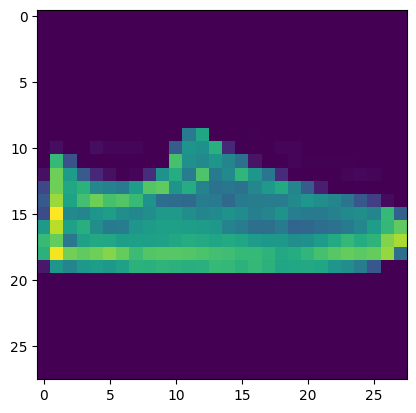

In [11]:
import matplotlib.pyplot as plt

# 의류 이미지가 맞는지 확인
plt.imshow(X[12].squeeze().numpy())

------------------------------------------------------------------------------------------




## 모델 만들기
PyTorch에서 신경망 모델은 [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) 을
상속받는 클래스(class)를 생성하여 정의합니다. ``__init__`` 함수에서 신경망의 계층(layer)들을 정의하고 ``forward`` 함수에서
신경망에 데이터를 어떻게 전달할지 지정합니다. 가능한 경우 GPU 또는 MPS로 신경망을 이동시켜 연산을 가속(accelerate)합니다.



In [14]:
# 학습에 사용할 CPU나 GPU, MPS 장치를 얻습니다.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# 모델을 정의합니다.
class NeuralNetwork(nn.Module):
    def __init__(self):
        ''' 계층 정의 '''
        super().__init__()
        self.flatten = nn.Flatten() # 이미지는 28 x 28 -> 1d-array
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10) # label이 10개이기 때문
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


[PyTorch에서 신경망을 정의하는 방법](buildmodel_tutorial.html) 을 자세히 알아보세요.




------------------------------------------------------------------------------------------




## 모델 매개변수 최적화하기
모델을 학습하려면 [손실 함수(loss function)](https://pytorch.org/docs/stable/nn.html#loss-functions) 와
[옵티마이저(optimizer)](https://pytorch.org/docs/stable/optim.html) 가 필요합니다.



In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) # 소수점 셋째 자리

각 학습 단계(training loop)에서 모델은 (배치(batch)로 제공되는) 학습 데이터셋에 대한 예측을 수행하고,
예측 오류를 역전파하여 모델의 매개변수를 조정합니다.



In [16]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 예측 오류 계산
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

모델이 학습하고 있는지를 확인하기 위해 테스트 데이터셋으로 모델의 성능을 확인합니다.



In [17]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

학습 단계는 여러번의 반복 단계 (*에폭(epochs)*) 를 거쳐서 수행됩니다. 각 에폭에서는 모델은 더 나은 예측을 하기 위해  매개변수를 학습합니다.
각 에폭마다 모델의 정확도(accuracy)와 손실(loss)을 출력합니다; 에폭마다 정확도가 증가하고 손실이 감소하는 것을 보려고 합니다.



In [18]:
epochs = 10 # 이곳 변형
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.310620  [   64/60000]
loss: 2.294365  [ 6464/60000]
loss: 2.272581  [12864/60000]
loss: 2.265742  [19264/60000]
loss: 2.253159  [25664/60000]
loss: 2.224419  [32064/60000]
loss: 2.236110  [38464/60000]
loss: 2.207234  [44864/60000]
loss: 2.194735  [51264/60000]
loss: 2.161203  [57664/60000]
Test Error: 
 Accuracy: 44.8%, Avg loss: 2.160901 

Epoch 2
-------------------------------
loss: 2.172584  [   64/60000]
loss: 2.162396  [ 6464/60000]
loss: 2.100892  [12864/60000]
loss: 2.115582  [19264/60000]
loss: 2.071826  [25664/60000]
loss: 2.014960  [32064/60000]
loss: 2.038263  [38464/60000]
loss: 1.966833  [44864/60000]
loss: 1.963474  [51264/60000]
loss: 1.883059  [57664/60000]
Test Error: 
 Accuracy: 59.0%, Avg loss: 1.889781 

Epoch 3
-------------------------------
loss: 1.923754  [   64/60000]
loss: 1.897320  [ 6464/60000]
loss: 1.773160  [12864/60000]
loss: 1.808213  [19264/60000]
loss: 1.704308  [25664/60000]
loss: 1.660135  [32064/600

[모델을 학습하는 방법](optimization_tutorial.html) 을 자세히 알아보세요.




------------------------------------------------------------------------------------------




## 모델 저장하기
모델을 저장하는 일반적인 방법은 (모델의 매개변수들을 포함하여) 내부 상태 사전(internal state dictionary)을
직렬화(serialize)하는 것입니다.



In [19]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## 모델 불러오기

모델을 불러오는 과정에는 모델 구조를 다시 만들고 상태 사전을 모델에 불러오는 과정이 포함됩니다.



In [20]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

이제 이 모델을 사용해서 예측을 할 수 있습니다.



In [21]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


[모델을 저장하고 불러오는 방법](saveloadrun_tutorial.html) 을 자세히 알아보세요.


